# Baseline Model Setup

## Import & Setup Tokenizer

In [1]:
import os
import time
import pandas as pd
import numpy as np
import torch
import datetime
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BertTokenizer, PreTrainedTokenizerBase, TrainerCallback, get_scheduler
from IPython.display import clear_output

tokenizer: PreTrainedTokenizerBase = BertTokenizer.from_pretrained("bert-base-uncased")

/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Import Data

In [2]:
# Load dataframes
splits = {
    'train': 'data/train-00000-of-00001.parquet',
    'validation': 'data/validation-00000-of-00001.parquet',
    'test': 'data/test-00000-of-00001.parquet'
}

train_df = pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["train"])
validation_df = pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["validation"])
test_df = pd.read_parquet("hf://datasets/stanfordnlp/sst2/" + splits["test"])

# Print the first 5 rows of the dataframes
print(train_df.head())
print(validation_df.head())
print(test_df.head())

   idx                                           sentence  label
0    0       hide new secretions from the parental units       0
1    1               contains no wit , only labored gags       0
2    2  that loves its characters and communicates som...      1
3    3  remains utterly satisfied to remain the same t...      0
4    4  on the worst revenge-of-the-nerds clichés the ...      0
   idx                                           sentence  label
0    0    it 's a charming and often affecting journey .       1
1    1                 unflinchingly bleak and desperate       0
2    2  allows us to hope that nolan is poised to emba...      1
3    3  the acting , costumes , music , cinematography...      1
4    4                  it 's slow -- very , very slow .       0
   idx                                           sentence  label
0    0             uneasy mishmash of styles and genres .     -1
1    1  this film 's relationship to actual tension is...     -1
2    2  by the end of no 

Data Fields
- idx: Monotonically increasing index ID.
- sentence: Complete sentence expressing an opinion about a film.
- label: Sentiment of the opinion, either "negative" (0) or positive (1). The test set labels are hidden (-1).

## Functions for Tokenization, Weak Labeling and Evaluation

In [3]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch['sentence'], padding="max_length", truncation=True, max_length=128)

# Convert and tokenize function with handling for empty datasets
def convert_and_tokenize(df):
    if "__index_level_0__" in df.columns:
        df = df.drop(columns=["__index_level_0__"])

    ds = Dataset.from_pandas(df)
    print(f"Before tokenization: {ds.column_names}")

    if "sentence" not in ds.column_names:
        raise ValueError("The 'sentence' column is missing in the dataset.")

    ds = ds.map(tokenize, batched=True)
    print(f"After tokenization: {ds.column_names}")

    required_columns = ["input_ids", "attention_mask", "label"]
    if set(required_columns).issubset(set(ds.column_names)):
        columns_to_remove = [col for col in ds.column_names if col not in required_columns]
        ds = ds.remove_columns(columns_to_remove)
    else:
        raise ValueError(f"Tokenization failed. Current columns: {ds.column_names}")

    return ds

# Weak labeling function
def weak_label(sentence):
    # Rule-based weak
    if "good" in sentence or "excellent" in sentence:
        return 1
    elif "bad" in sentence or "terrible" in sentence:
        return 0
    else:
        return -1

# Metrics function for evaluation
def compute_metrics(p):
    preds = torch.argmax(torch.tensor(p.predictions), dim=1).numpy()
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

## Setup Device, Tokenizer and Model

In [4]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Applying weak labeling to the test dataset

In [5]:
# Weak labeling for test_df
print("Applying weak labeling to the test dataset...")
test_df["label"] = test_df["sentence"].apply(weak_label)

# Remove -1 labels
test_df = test_df[test_df["label"] != -1]

if test_df.empty:
    print("The test dataset is empty after weak labeling.")
    test_ds = None
else:
    print(f"Test dataset size after weak labeling: {len(test_df)}")
    test_ds = convert_and_tokenize(test_df)

Applying weak labeling to the test dataset...
Test dataset size after weak labeling: 116
Before tokenization: ['idx', 'sentence', 'label', '__index_level_0__']


After tokenization: ['idx', 'sentence', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask']


Weak labeling is a technique used to assign pseudo-labels to unlabeled data based on predefined rules or heuristics. In this case, it was applied to the `test_df`, which originally contained only `-1` values, indicating that the dataset was unlabeled and unsuitable for evaluation. To address this, we implemented a rule-based weak labeling function that assigns a label of `1` (positive) to sentences containing words like "good" or "excellent" and a label of `0` (negative) to those with words like "bad" or "terrible." Sentences that do not match any rule were labeled `-1` and subsequently removed from the dataset. This allowed us to create a usable test dataset with meaningful labels, enabling the evaluation of the model despite the absence of ground-truth annotations in the original test data.

## Train Model

In [6]:
# Use a sample of the data for quick testing
train_df_sample = train_df.sample(n=5000, random_state=128)

# Convert and tokenize the sample datasets
train_ds = convert_and_tokenize(train_df)
validation_ds = convert_and_tokenize(validation_df)

Before tokenization: ['idx', 'sentence', 'label']


After tokenization: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask']
Before tokenization: ['idx', 'sentence', 'label']


After tokenization: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


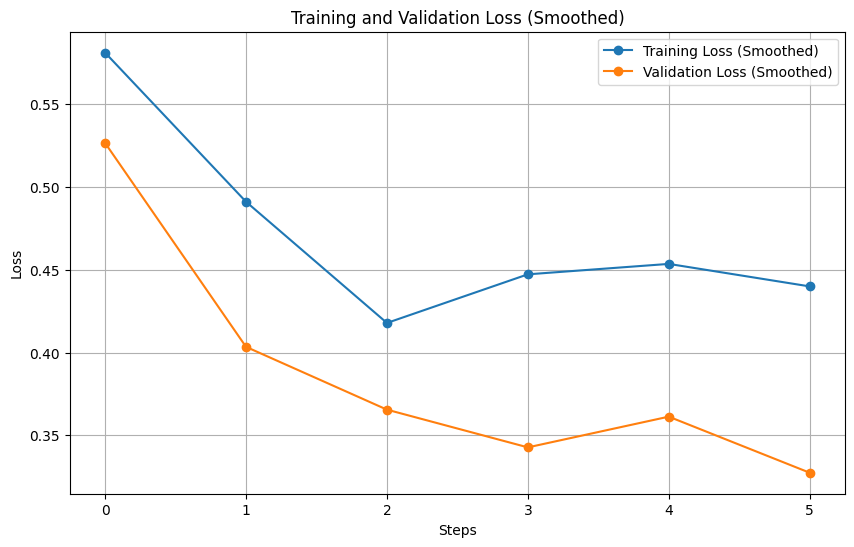

  2%|▏         | 200/8419 [04:59<3:25:19,  1.50s/it]

{'train_runtime': 299.6881, 'train_samples_per_second': 224.73, 'train_steps_per_second': 28.093, 'train_loss': 0.48349882125854493, 'epoch': 0.02}
Training completed in 300.31 seconds.
Saving the model to ./saved_model_20241205_221704...


In [7]:
# Generate a unique save path for each training session
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f"./saved_model_{timestamp}"

# Timer
start_time = time.time()

# Moving average function for smoothing the curves
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Callback for tracking and plotting losses dynamically
class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Track training and evaluation losses
        if "loss" in logs:
            self.train_losses.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_losses.append(logs["eval_loss"])

        # Plot dynamically with smoothing
        if len(self.train_losses) > 2:  # At least three points for smoothing
            clear_output(wait=True)
            train_smoothed = moving_average(self.train_losses)
            eval_smoothed = moving_average(self.eval_losses) if len(self.eval_losses) > 2 else self.eval_losses
            plt.figure(figsize=(10, 6))
            plt.plot(train_smoothed, label="Training Loss (Smoothed)", marker='o')
            plt.plot(eval_smoothed, label="Validation Loss (Smoothed)", marker='o')
            plt.xlabel("Steps")
            plt.ylabel("Loss")
            plt.title("Training and Validation Loss (Smoothed)")
            plt.legend()
            plt.grid(True)
            plt.show()

# Callback for early stopping based on validation loss
class EarlyStoppingByValLoss(EarlyStoppingCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Monitor eval_loss for early stopping
        if "eval_loss" in metrics:
            current_loss = metrics["eval_loss"]
            if (
                state.best_metric is None
                or current_loss < state.best_metric - self.early_stopping_threshold
            ):
                state.best_metric = current_loss
                state.best_model_checkpoint = f"{args.output_dir}/checkpoint-{state.global_step}"
                state.early_stopping_patience = 0
            else:
                state.early_stopping_patience += 1
                if state.early_stopping_patience >= self.early_stopping_patience:
                    print(f"Early stopping triggered after {self.early_stopping_patience} evaluations at step {state.global_step}.")
                    control.should_training_stop = True

# Callback for printing time estimation
class TimeRemainingCallback(TrainerCallback):
    def __init__(self, total_steps):
        self.total_steps = total_steps
        self.start_time = None

    def format_time(self, seconds):
        """Converts seconds to a formatted string of hours and minutes."""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        return f"{hours}h {minutes}min"

    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.global_step > 0 and state.global_step % 100 == 0:  # Print every 100 steps
            elapsed_time = time.time() - self.start_time
            steps_completed = state.global_step
            steps_remaining = self.total_steps - steps_completed
            time_per_step = elapsed_time / steps_completed
            estimated_time_remaining = steps_remaining * time_per_step

            print(
                f"Progress: {steps_completed}/{self.total_steps} | "
                f"Elapsed Time: {self.format_time(elapsed_time)} | "
                f"Estimated Time Remaining: {self.format_time(estimated_time_remaining)}"
            )

# Training arguments
training_args = TrainingArguments(
    output_dir=f"./results_{timestamp}",
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=50,  # Save every 50 steps
    logging_steps=25,  # Log every 25 steps for better insights
    logging_dir=f"./logs_{timestamp}",
    report_to=["none"],  # Disable external log reporting
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # Adjust for stable gradients
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=1000
)

# Total number of steps (manually calculated for the dataset)
total_training_steps = len(train_ds) // training_args.per_device_train_batch_size

# Initialize trainer with custom callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=validation_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingByValLoss(early_stopping_patience=2, early_stopping_threshold=0.001),
        TimeRemainingCallback(total_steps=total_training_steps),
        LossTrackerCallback(),
    ],
)

# Check if the new model directory exists (it won't, as it is unique)
if os.path.exists(model_save_path):
    print(f"Model already exists at {model_save_path}.")
else:
    print("Training started...")
    trainer.train()
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds.")

    # Save model and tokenizer in the unique directory
    print(f"Saving the model to {model_save_path}...")
    trainer.save_model(model_save_path)
    tokenizer.save_pretrained(model_save_path)

## Evaluation

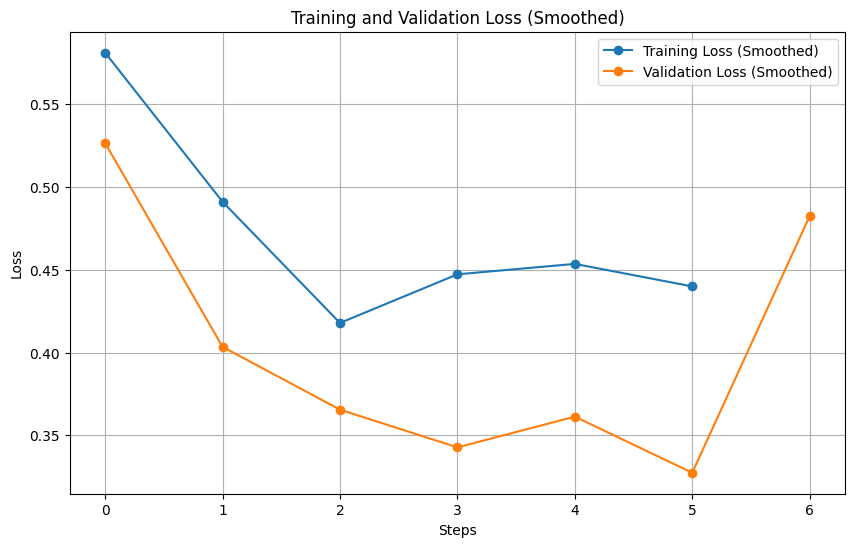

100%|██████████| 15/15 [00:02<00:00,  5.97it/s]

Early stopping triggered after 2 evaluations at step 200.

Evaluation Results:
eval_loss: 0.7549
eval_accuracy: 0.7241
eval_precision: 0.9388
eval_recall: 0.6133
eval_f1: 0.7419
eval_runtime: 2.7273
eval_samples_per_second: 42.5330
eval_steps_per_second: 5.5000
Evaluation results saved to ./evaluation_results_20241205_221704.txt.


In [8]:
# Check if the test dataset exists
if test_ds is None or len(test_ds) == 0:
    print("Test dataset is empty. Unable to evaluate.")
else:
    print("Evaluating on the test dataset...")
    results = trainer.evaluate(test_ds)
    print("\nEvaluation Results:")
    for metric, value in results.items():
        if metric.startswith("eval_"):
            print(f"{metric}: {value:.4f}")

# Optional: Save evaluation results for later analysis
results_save_path = f"./evaluation_results_{timestamp}.txt"
with open(results_save_path, "w") as f:
    for metric, value in results.items():
        if metric.startswith("eval_"):
            f.write(f"{metric}: {value:.4f}\n")
    print(f"Evaluation results saved to {results_save_path}.")

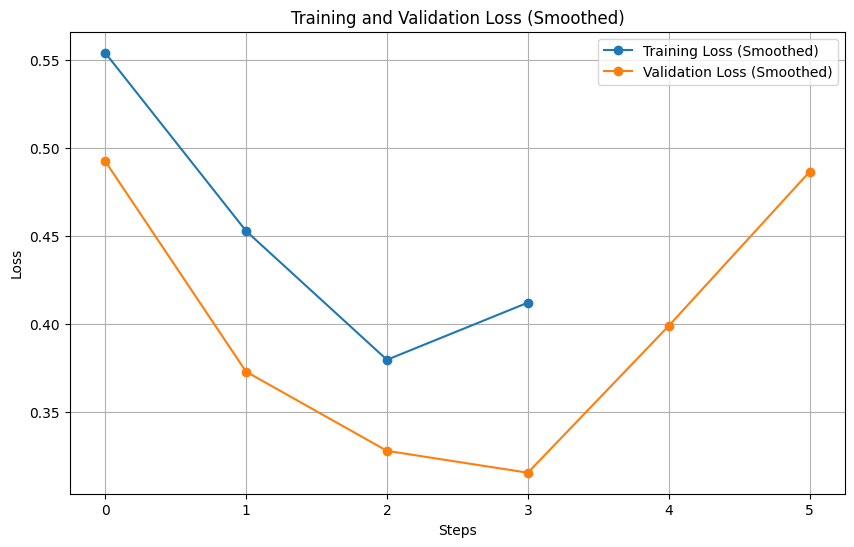

100%|██████████| 15/15 [00:02<00:00,  6.34it/s]

Early stopping triggered after 1 evaluations at step 150.
Test Results: {'eval_loss': 0.5726984143257141, 'eval_accuracy': 0.6982758620689655, 'eval_precision': 0.9347826086956522, 'eval_recall': 0.5733333333333334, 'eval_f1': 0.7107438016528925, 'eval_runtime': 2.516, 'eval_samples_per_second': 46.106, 'eval_steps_per_second': 5.962, 'epoch': 0.017816842855446016}


In [9]:
# Evaluate the model
if test_ds:
    results = trainer.evaluate(test_ds)
    print("Test Results:", results)
else:
    print("Skipping evaluation as test dataset is empty.")

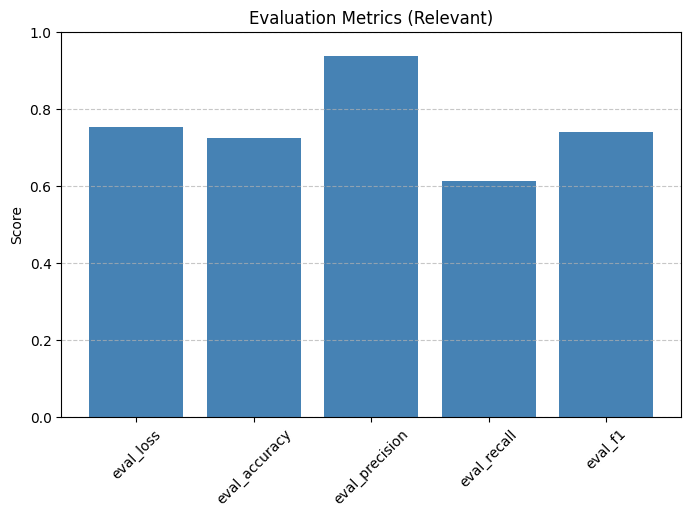

In [11]:
# Filter relevant metrics for visualization
if test_ds is not None and len(test_ds) > 0:
    relevant_metrics = {k: v for k, v in results.items() if k in ["eval_loss", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]}
    
    # Create a bar plot for the relevant metrics
    plt.figure(figsize=(8, 5))
    plt.bar(relevant_metrics.keys(), relevant_metrics.values(), color="steelblue")
    plt.title("Evaluation Metrics (Relevant)")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Assuming metrics are scaled between 0 and 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print("Test dataset is empty or not available.")